In [1]:
import os
import matplotlib.pyplot as plt
from PIL import Image # For handling the images
import numpy as np
import pandas as pd
import math
import seaborn as sns

# Import different Keras functionalities
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Flatten, Dropout, concatenate, BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
from sklearn import metrics
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from pathlib import Path

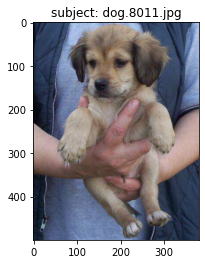

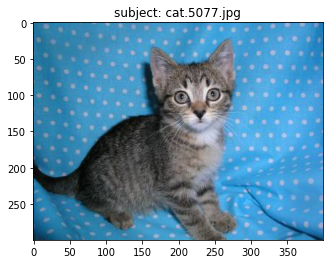

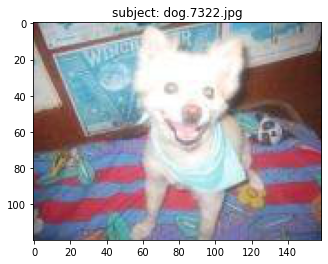

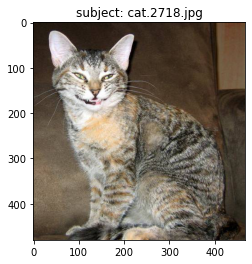

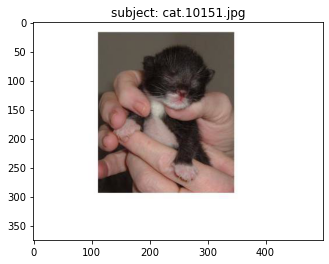

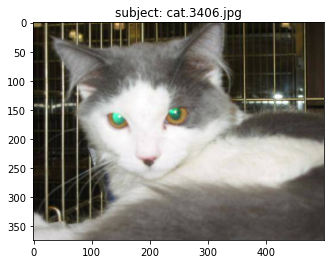

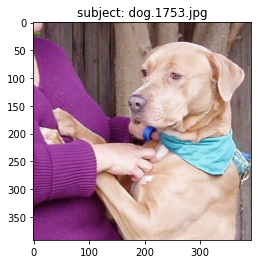

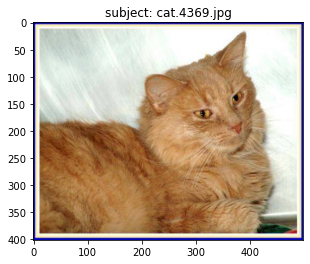

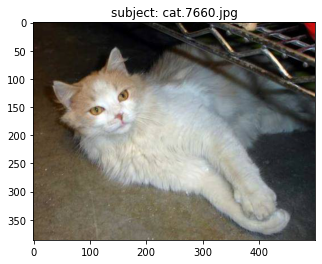

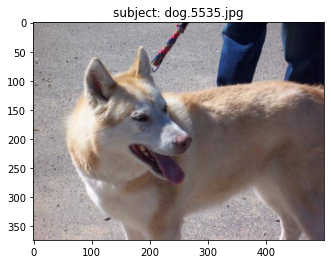

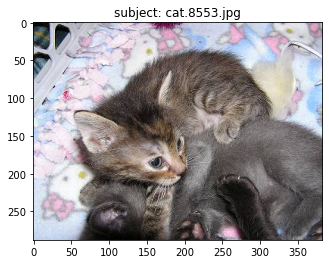

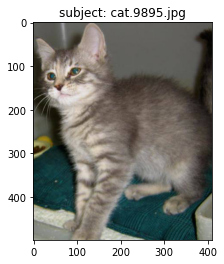

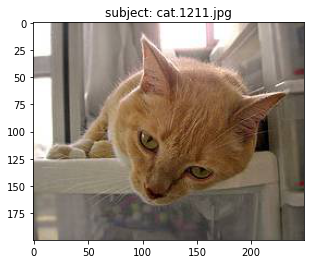

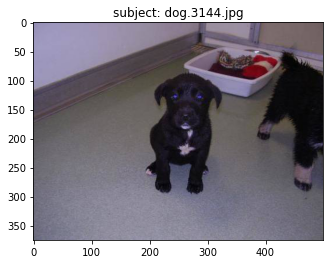

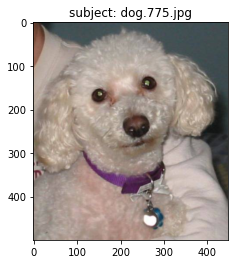

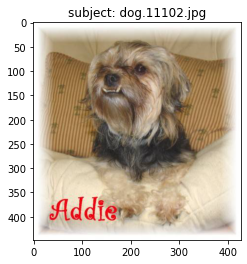

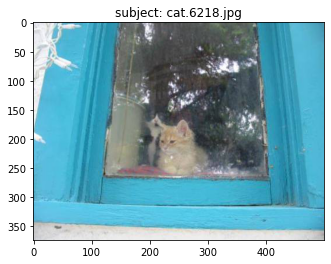

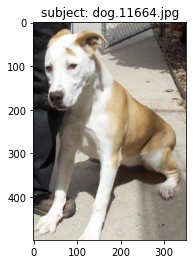

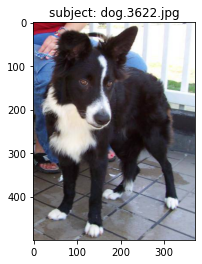

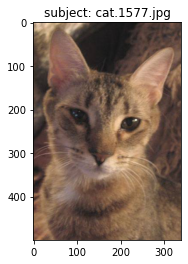

In [2]:
path_subjects = "../DATA/dogs-vs-cats/dataset"
count=0
for f_name in os.listdir(path_subjects):
    if(count<20):
        img = Image.open(path_subjects + '/' + f_name)
        plt.imshow(img, vmin=0, vmax=255)
        plt.title('subject: ' + str(f_name))
        plt.show()
        count+=1

In [3]:
experiment_rootdir = './CNN-Transfer-results-Resnet/'
weights_path = './CNN-Transfer-results-Resnet/weights.h5'
loss_img_name = './CNN-Transfer-results-Resnet/loss.png'
accuracy_img_name = './CNN-Transfer-results-Resnet/accuracy.png'
graph_loss_acc = './CNN-Transfer-results-Resnet/loss-acc-comparation.png'
weights_file = Path(weights_path)

if not os.path.exists(experiment_rootdir):
    os.makedirs(experiment_rootdir)

In [4]:
# Randomize the initial network weights
random_seed = True

# Parameters that characterizes the images, size and image type
img_width=128
img_height=128
img_channels=3
img_mode='rgb'

# Parameters that configures the training process
batch_size=32
epochs = 20
lrate = 0.001
min_lrate = 0.00001

In [5]:
filenames=os.listdir("../DATA/dogs-vs-cats/dataset")
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='dog':
        categories.append(1)
    else:
        categories.append(0)
df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

In [6]:
def getModelVGG(img_width,img_height,img_channels):
    # I have based my solution in the following link:
    #https://medium.com/analytics-vidhya/image-classification-cats-and-dogs-pre-trained-neural-network-vs-constructed-6370d5c79fde
    shape_image = (img_width,img_height,img_channels)
    model = VGG16(
        weights= None, #Train from scratch parameter None or train with 'imagenet'
        include_top = True, #try true and false for all layers conected
        input_shape = shape_image,
        input_tensor=None,
        pooling=None,
        classes=2,
    )
    return model

In [7]:
def getModelResnet50(img_width,img_height,img_channels):
    # I have based my solution in the following link:
    #https://www.kaggle.com/suniliitb96/tutorial-keras-transfer-learning-with-resnet50
    shape_image = (img_width,img_height,img_channels)
    model = ResNet50(
        weights= None, #Train from scratch parameter None or train with 'Imagenet'
        include_top = True, #try true and false for all layers conected
        input_shape = shape_image,
        input_tensor=None,
        pooling=None,
        classes=2,
    )
    # Return the model itself
    return model

In [8]:
def trainModel(model):
    # Configure the trainig process by compiling the model. Select the loss fucntion, the optimizer, and the metric used to obtain results.
    #sgd = SGD(lr = lrate, decay = 0, momentum = 0.9, nesterov = False)
    adam = Adam(learning_rate=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    #rmsprop = RMSprop(learning_rate=lrate, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False)
    model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics = ['accuracy'])
    print(model.summary())
    # Define training and validation steps taking into account the number of samples for each process and the batch size    
    STEPS_PER_EPOCH_TRAINING =  total_train// batch_size
    STEPS_PER_EPOCH_VALIDATION =  total_validate// batch_size
    # Fit the model by using the fit generator
    cb_checkpointer = ModelCheckpoint(filepath = weights_path, monitor = 'val_loss', save_best_only = True, mode="auto")
    #earlystop = EarlyStopping(monitor='val_loss', patience = 10)
    #learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',patience = 5,verbose = 1,factor = 0.5, min_lr = min_lrate)

    history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH_TRAINING,
        epochs = epochs,
        validation_data=validation_generator,
        validation_steps=STEPS_PER_EPOCH_VALIDATION,
        callbacks=[cb_checkpointer]
    )
    # Return the history of the model to plot the loss and accuracy evolution
    return history

In [9]:
df["category"] = df["category"].replace({0:'cat',1:'dog'})

train_df ,validate_df = train_test_split(df,test_size=0.20,random_state=1, shuffle=True)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df ,test_df = train_test_split(train_df,test_size=0.25,random_state=1, shuffle=True)
test_df = test_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
total_test=test_df.shape[0]

In [10]:
# Set random seed
if random_seed:
    seed = np.random.randint(0,2*31-1)
else:
    seed = 5
np.random.seed(seed)
tf.random.set_seed(seed)

#Using ImageGenerator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "../DATA/dogs-vs-cats/dataset/",
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
   )

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../DATA/dogs-vs-cats/dataset/", 
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
    )

Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [11]:
#vggModel = getModelVGG(img_width,img_height,img_channels)
resnetModel = getModelResnet50(img_width,img_height,img_channels)
history = trainModel(resnetModel)
resnetModel.save_weights(weights_path)

2022-01-18 19:47:46.330657: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 64, 64, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

/Users/isabel.rodriguez/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-01-18 19:47:47.415733: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
468/468 [==============================] - 1321s 3s/step - loss: 0.8165 - accuracy: 0.5792 - val_loss: 0.7395 - val_accuracy: 0.5292


/Users/isabel.rodriguez/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/20
468/468 [==============================] - 1287s 3s/step - loss: 0.6344 - accuracy: 0.6539 - val_loss: 6.2396 - val_accuracy: 0.5248
Epoch 3/20
468/468 [==============================] - 1275s 3s/step - loss: 0.5788 - accuracy: 0.7022 - val_loss: 0.7182 - val_accuracy: 0.6162
Epoch 4/20
468/468 [==============================] - 4348s 9s/step - loss: 0.5425 - accuracy: 0.7334 - val_loss: 1.7870 - val_accuracy: 0.5847
Epoch 5/20
468/468 [==============================] - 1379s 3s/step - loss: 0.5152 - accuracy: 0.7519 - val_loss: 0.5805 - val_accuracy: 0.6983
Epoch 6/20
468/468 [==============================] - 1529s 3s/step - loss: 0.4660 - accuracy: 0.7815 - val_loss: 0.8614 - val_accuracy: 0.5769
Epoch 7/20
468/468 [==============================] - 1646s 4s/step - loss: 0.4596 - accuracy: 0.7869 - val_loss: 1.2138 - val_accuracy: 0.5863
Epoch 8/20
468/468 [==============================] - 6672s 14s/step - loss: 0.4028 - accuracy: 0.8148 - val_loss: 0.7815 - val_accuracy

In [12]:
test_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
    )

test_generator = test_datagen.flow_from_dataframe(    
    test_df,
    "../DATA/dogs-vs-cats/dataset/", 
    x_col='filename',
    y_col='category',
    target_size=(img_width,img_height),
    class_mode='categorical',
    batch_size=batch_size,
    color_mode=img_mode,
   )

Found 5000 validated image filenames belonging to 2 classes.


In [17]:
#vggModel = getModelVGG(img_width,img_height,img_channels)
resnetModel = getModelResnet50(img_width,img_height,img_channels)
# Load saved weights
try:
    resnetModel.load_weights(weights_path)
    print("Loaded model from {}".format(weights_path))
except:
    print("Impossible to find weight path. Returning untrained model")

# Compile model
#sgd = SGD(lr=lrate, momentum=0.9, decay=0, nesterov=False)
adam = Adam(learning_rate=lrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
resnetModel.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

# Get predictions using predict_generator function
STEPS_PER_EPOCH_TEST = int(round(total_test//(batch_size-2)))
predict = resnetModel.predict_generator(test_generator, steps=STEPS_PER_EPOCH_TEST)

Loaded model from ./CNN-Transfer-results-imagenet-VGG/weights.h5


/Users/isabel.rodriguez/opt/anaconda3/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [18]:
test_df['category_predicted'] = np.argmax(predict, axis=1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category_predicted'] = test_df['category_predicted'].replace(label_map)
test_df['category_predicted'] = test_df['category_predicted'].replace({ 'dog': 1, 'cat': 0 })
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

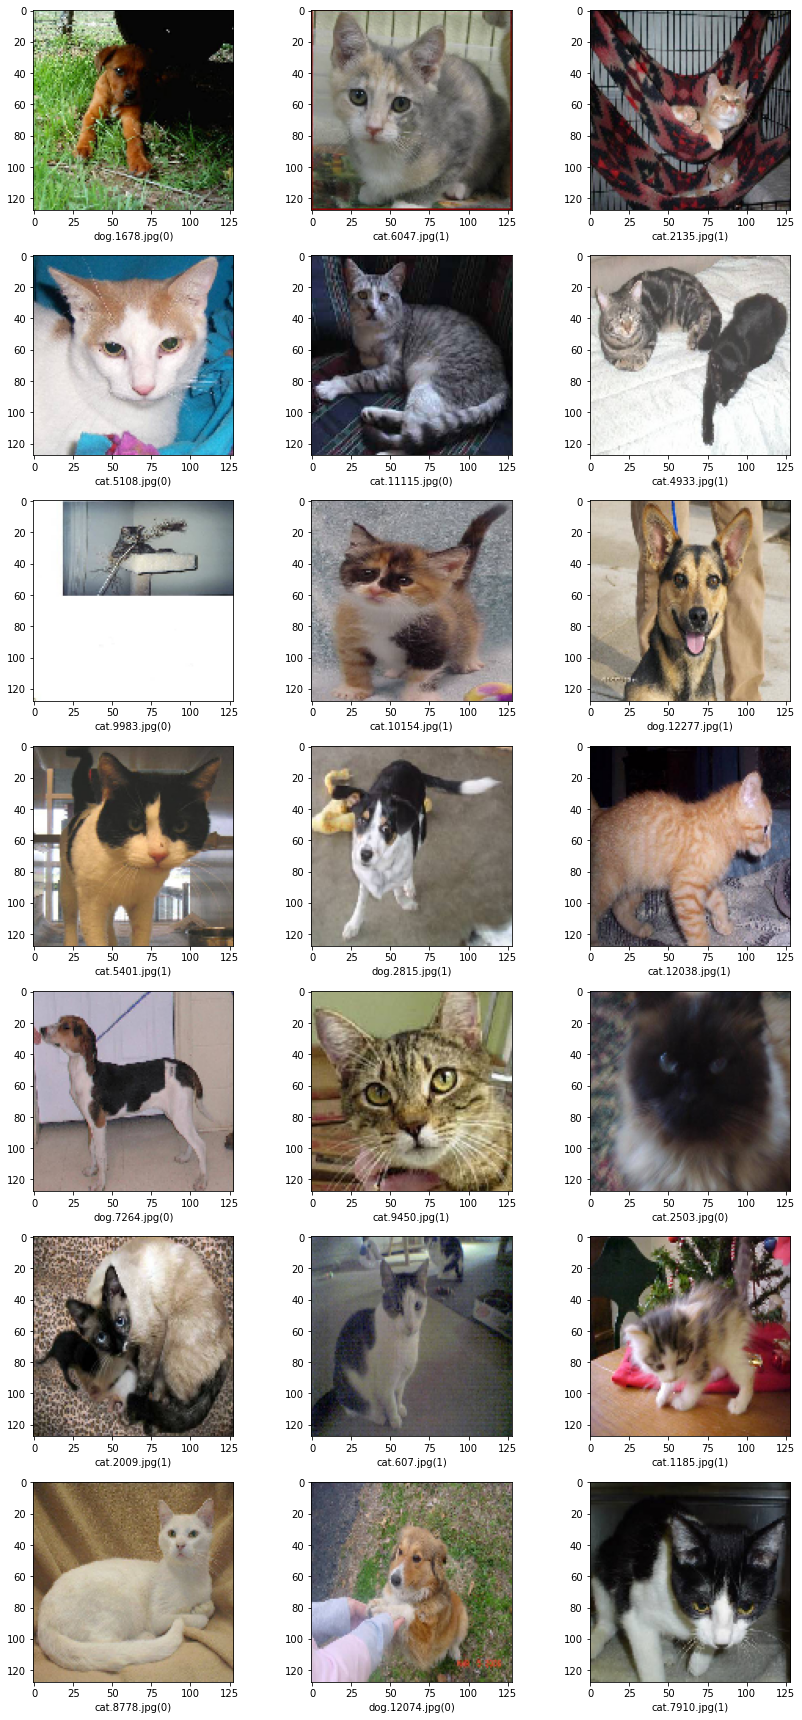

<Figure size 432x288 with 0 Axes>

In [19]:
sample_test = test_df.sample(21).reset_index(drop = True)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category_predicted']
    img = load_img("../DATA/dogs-vs-cats/dataset/"+filename, target_size=(img_width,img_height))
    plt.subplot(7, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()
plt.savefig('./CNN-Transfer-results-imagenet-vgg/test.png')

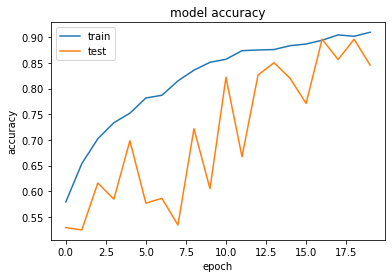

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(accuracy_img_name)

# Show figure
plt.show()

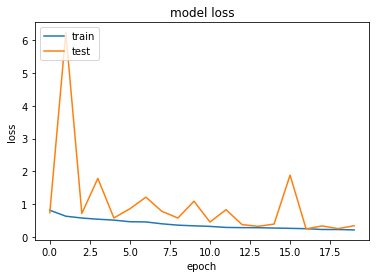

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(loss_img_name)

# Show figure
plt.show()

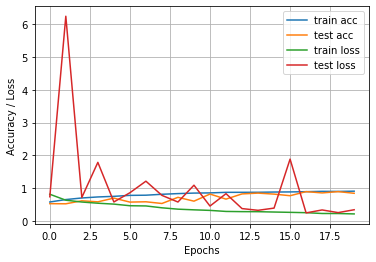

In [22]:
# Plot the accuracy curves
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


# Plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Accuracy / Loss')
plt.legend(['train acc', 'test acc','train loss', 'test loss'])
plt.grid()

plt.savefig(graph_loss_acc)

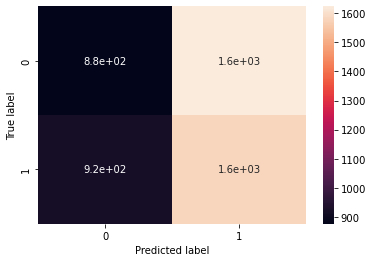

In [23]:
confusion_matrix = metrics.confusion_matrix(test_df['category'], test_df['category_predicted'])#pd.crosstab(test_df['category'], test_df['category_predicted'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
fig_save_path = os.path.join(experiment_rootdir, "CM.png")
plt.savefig(fig_save_path)
plt.show()